<a href="https://colab.research.google.com/github/iceQHdrop/bioinformatic_data_mining/blob/main/WAM_for_function_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WAM_for_function_finding

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! cp -r drive/MyDrive/Colab_Notebooks/bioinformatic_data_mining/dataset ./

## 导入所需库

In [4]:
import pandas as pd 
import numpy as np
import xarray as xr    # 处理三维数据
from tqdm import tqdm    # 进度条
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from plotnine import*

%matplotlib inline

## 设定路径，读取文件名

In [5]:
train_path = 'dataset/TrainingSet'
test_path = 'dataset/TestingSet'    
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

## WAM

### 处理训练数据

#### 碱基计数

In [6]:
site_base_count = pd.DataFrame(np.zeros((9, 4)),    # 记录位点周围碱基数
                               columns = ['a', 't', 'c', 'g'],
                               index = [i-3 for i in range(9)])

site_forward_count = xr.DataArray(np.zeros((9, 4, 4)),    # 记录位点周围当前一个碱基确定时碱基数
                                  dims = ['position', 'forward', 'self'],
                                  coords = [[i-3 for i in range(9)],
                        ['a', 't', 'c', 'g'],
                        ['a', 't', 'c', 'g']])

background_forward_count = pd.DataFrame(np.zeros((4, 4)),    # 记录背景当前一个碱基确定时碱基数
                                     columns = ['a', 't', 'c', 'g'],
                                     index = ['a', 't', 'c', 'g'])
site_seqs = []
whole_seq = ''

print('Loading data and counting base, this could be time consuming...')

for train_file in tqdm(train_files):
    with open(train_path + '/' + train_file, 'r') as f:
        text = f.readlines()
        site_positions = re.findall('(\d+)(?=,)', text[1])    # 提取位置
        seq = ''.join(text[2:]).replace('\n', '').lower()    # 仅保留小写序列

        for position in site_positions:
            site_seqs.append(seq[int(position) - 4:int(position) + 5])    # 提取位点序列

            for i in range(9):    # 统计位点周围9个位置的碱基
                if int(position) - 1 + (i - 3) > 0:    # 排除在基因前三个碱基的位点
                    base = seq[int(position) - 1 + (i - 3)]    
                    site_base_count.loc[i-3, base] += 1

            for i in range(8):    # 统计位点周围9个位置的碱基，当前一个碱基确定时的数目
                if int(position) - 1 + (i - 3) > 0:
                    base = seq[int(position) - 1 + (i - 2)]   
                    forward_base = seq[int(position) - 1 + (i - 3)]
                    site_forward_count.loc[i-2, forward_base, base] += 1
            
        for i in range(len(seq)-1):    # 统计背景碱基当前一个碱基确定时的数目，费时，保存后可注释掉
            base = seq[i+1]
            forward_base = seq[i]
            try:    # 越过'n'
                background_forward_count.loc[forward_base, base] += 1
            except:
                continue

        whole_seq += seq

Loading data and counting base...


100%|██████████| 462/462 [00:29<00:00, 15.91it/s]


保存背景概率矩阵，方便调试

In [ ]:
background_forward_count.to_csv('dataset/background_forward_matrix.csv')

读取先前计算好的背景概率矩阵

In [7]:
background_forward_count = pd.read_csv('dataset/background_forward_matrix.csv', index_col = 0)

#### 构建前景概率矩阵

构建不考虑前一个碱基的概率矩阵

In [8]:
matrix_pos = site_base_count/len(site_seqs)
matrix_pos

,a,t,c,g
-3,0.270055,0.183536,0.305334,0.241075
-2,0.328433,0.119278,0.363713,0.188576
-1,0.585468,0.143217,0.137757,0.133557
0,0.094078,0.083158,0.034019,0.788744
1,0.000000,0.000000,0.000000,1.000000
2,0.000000,1.000000,0.000000,0.000000
3,0.490130,0.024360,0.027299,0.458211
4,0.713566,0.091558,0.077278,0.117598
5,0.065099,0.047039,0.049559,0.838303


构建考虑前一个碱基的概率矩阵

In [9]:
matrix_forward_pos = site_forward_count.copy()

for base in ['a', 't', 'c', 'g']:
    matrix_forward_pos.loc[:, base] = matrix_forward_pos.loc[:, base]/matrix_forward_pos.loc[:, base].sum(axis = 1)

matrix_forward_pos = matrix_forward_pos.fillna(0)
matrix_forward_pos

<xarray.DataArray (position: 9, forward: 4, self: 4)>
array([[[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.3125972 , 0.14152411, 0.30948678, 0.23639191],
        [0.1624714 , 0.13043478, 0.40732265, 0.29977117],
        [0.39614856, 0.1389271 , 0.3823934 , 0.08253095],
        [0.38675958, 0.06097561, 0.36759582, 0.18466899]],

       [[0.61636829, 0.13682864, 0.0971867 , 0.14961637],
        [0.18309859, 0.23943662, 0.24647887, 0.33098592],
        [0.6778291 , 0.13972286, 0.12355658, 0.05889145],
        [0.60801782, 0.10022272, 0.16703786, 0.1247216 ]],

       [[0.07388809, 0.05308465, 0.01865136, 0.8543759 ],
        [0.03519062, 0.08211144, 0.03225806, 0.85043988],
        [0.18902439, 0.21646341, 0.07012195, 0.52439024],
        [0.14779874, 0.07861635, 0.06603774, 0.70754717]],

...

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.4901302 , 0.02435951, 0.02729945, 0.45821084],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.64610111, 0.13624679, 0.09597258, 0.12167952],
        [0.34482759, 0.22413793, 0.06896552, 0.36206897],
        [0.67692308, 0.18461538, 0.03076923, 0.10769231],
        [0.80751604, 0.03116407, 0.06049496, 0.10082493]],

       [[0.05768099, 0.03296057, 0.02707475, 0.8822837 ],
        [0.04587156, 0.06422018, 0.07798165, 0.81192661],
        [0.16304348, 0.18478261, 0.22282609, 0.42934783],
        [0.06071429, 0.02857143, 0.05      , 0.86071429]]])
Coordinates:
  * position  (position) int64 -3 -2 -1 0 1 2 3 4 5
  * forward   (forward) <U1 'a' 't' 'c' 'g'
  * self      (self) <U1 'a' 't' 'c' 'g'

#### 构建背景概率矩阵

构建不考虑前一个碱基的概率矩阵

In [10]:
whole_seq.replace('n', '')
p_neg = [whole_seq.count(base)/len(whole_seq) for base in ['a', 't', 'c', 'g']]  
matrix_neg = pd.DataFrame(np.tile(p_neg, (9, 1)),
                          columns = ['a', 't', 'c', 'g'],
                          index = [i-3 for i in range(9)])
matrix_neg

,a,t,c,g
-3,0.260085,0.271169,0.23217,0.236428
-2,0.260085,0.271169,0.23217,0.236428
-1,0.260085,0.271169,0.23217,0.236428
0,0.260085,0.271169,0.23217,0.236428
1,0.260085,0.271169,0.23217,0.236428
2,0.260085,0.271169,0.23217,0.236428
3,0.260085,0.271169,0.23217,0.236428
4,0.260085,0.271169,0.23217,0.236428
5,0.260085,0.271169,0.23217,0.236428


构建考虑前一个碱基的概率矩阵

In [11]:
matrix_forward_neg = background_forward_count.apply(lambda x: x/x.sum(), axis = 1)
matrix_forward_neg

,a,t,c,g
a,0.296923,0.234069,0.187147,0.281861
t,0.186917,0.308036,0.223690,0.281356
c,0.307009,0.322820,0.294622,0.075548
g,0.257592,0.219191,0.230213,0.293004


### 定义$S(X)$

In [12]:
def WAMDecisionFunction(seq):
    score = (np.log(matrix_pos.loc[-3, seq[0]] + 1)/matrix_neg.loc[-3, seq[0]])

    for i in range(8):
        score += (np.log(matrix_forward_pos.loc[i-2, seq[i], seq[i+1]] + 1))/matrix_forward_neg.loc[seq[i], seq[i+1]]

    return float(score)

### 寻找阈值 

#### 计算位点序列得分

In [13]:
scores = [WAMDecisionFunction(seq) for seq in site_seqs]
scores = np.array(scores)
scores

array([15.12975447, 14.45378518, 19.53542529, ..., 15.34128458,
       16.24095355, 15.14095067])

#### 计算召回率

In [14]:
threshold = np.linspace(scores.min(), scores.max(), 50)

recall = [np.sum(scores > thr)/scores.shape for thr in threshold]
recall = np.array(recall).reshape(-1)
recall

array([9.99580008e-01, 9.99580008e-01, 9.99580008e-01, 9.98740025e-01,
       9.98740025e-01, 9.97480050e-01, 9.96640067e-01, 9.95800084e-01,
       9.94540109e-01, 9.91600168e-01, 9.89500210e-01, 9.87820244e-01,
       9.78580428e-01, 9.62620748e-01, 9.33221336e-01, 9.08021840e-01,
       8.42503150e-01, 7.80344393e-01, 7.21965561e-01, 6.48467031e-01,
       5.66568669e-01, 4.90550189e-01, 4.48131037e-01, 3.65812684e-01,
       3.30953381e-01, 3.23393532e-01, 2.78874423e-01, 2.31835363e-01,
       1.29357413e-01, 1.05417892e-01, 9.61780764e-02, 9.40781184e-02,
       9.23981520e-02, 8.48383032e-02, 7.72784544e-02, 6.04787904e-02,
       3.90592188e-02, 3.44393112e-02, 3.23393532e-02, 3.06593868e-02,
       2.47795044e-02, 1.80596388e-02, 1.25997480e-02, 9.23981520e-03,
       7.55984880e-03, 4.19991600e-03, 8.39983200e-04, 4.19991600e-04,
       4.19991600e-04, 0.00000000e+00])

#### 绘制阈值与召回率关系图

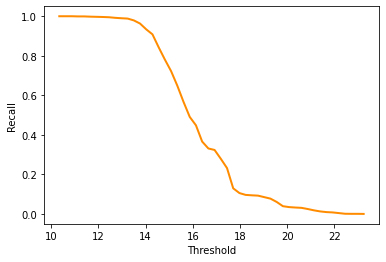

In [15]:
plt.figure()
lw = 2
plt.plot(
    threshold,
    recall,
    color = 'darkorange',
    lw = lw,
    )
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

### 处理测试数据

#### 导入并提取序列

In [17]:
test_site_seqs = []
test_normal_seqs = []

print('Loading testing data...')

for test_file in tqdm(test_files):
    with open(test_path + '/' + test_file, 'r') as f:
        text = f.readlines()
        test_site_positions = re.findall('(\d+)(?=,)', text[1])    # 提取位置
        seq = ''.join(text[2:]).replace('\n', '').lower()
        
        for position in test_site_positions:
            test_site_seqs.append(seq[int(position) - 4:int(position) + 5])
        
        for num in range(4):    # 提取非位点序列
            test_normal_position = np.random.randint(len(seq) - 9)    # 采样至倒数第九位
            test_normal_seq = seq[test_normal_position - 4:test_normal_position + 5]

            while test_normal_position in test_site_positions or \
                set(test_normal_seq) != {'a', 't', 'c', 'g'} or  \
                len(test_normal_seq) != 9:    # 排除donar位点与'n', 'm' 等

                test_normal_position = np.random.randint(len(seq) - 9)
                test_normal_seq = seq[test_normal_position - 4:test_normal_position + 5]

            test_normal_seqs.append(test_normal_seq)

Loading testing data...


100%|██████████| 570/570 [00:00<00:00, 3435.77it/s]


#### 构建数据集

In [18]:
test_site_df = pd.DataFrame(list(zip(test_site_seqs, np.ones(len(test_site_seqs)))),    # 位点
                            columns = ['Seq', 'Donar'])

test_normal_df = pd.DataFrame(list(zip(test_normal_seqs, np.zeros(len(test_normal_seqs)))),    # 非位点
                              columns = ['Seq', 'Donar'])

test_df = pd.concat([test_site_df, test_normal_df]).reset_index(drop = True)
test_df.head()

,Seq,Donar
0,caaagtaag,1.0
1,ggaggtgag,1.0
2,caaggtgag,1.0
3,acaggtagg,1.0
4,tcaagtaag,1.0


#### 计算每一条序列得分

In [19]:
test_df['Score'] = test_df['Seq'].apply(WAMDecisionFunction)
# test_df['Score'].fillna(-100, inplace = True)    # 去除空值
test_df

,Seq,Donar,Score
0,caaagtaag,1.0,15.769891
1,ggaggtgag,1.0,16.937481
2,caaggtgag,1.0,17.453480
3,acaggtagg,1.0,16.425056
4,tcaagtaag,1.0,15.752552
...,...,...,...
4354,tggacaagg,0.0,5.016232
4355,tggaccccc,0.0,3.275204
4356,tcctgatct,0.0,6.438307
4357,gaagcagtc,0.0,6.466692


#### 计算AUROC

In [20]:
fpr, tpr, _ = roc_curve(test_df['Donar'], test_df['Score'])
roc_auc = auc(fpr, tpr)
roc_auc

0.9921593757120073

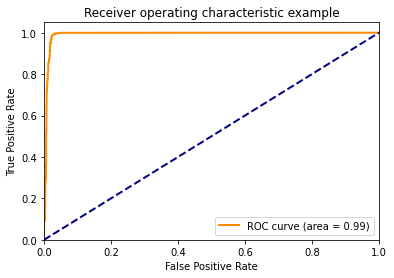

In [21]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color = "darkorange",
    lw = lw,
    label = "ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")